In [8]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import example_utils as ex_utils

from MARBLE import utils, geometry, net, plotting, postprocessing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# For initial conditions, sample a rectangle uniformly

In [2]:
t0, t1, dt = 0, 3, 0.5
t = np.arange(t0, t1, dt)
n = 100
area = [[-3,-3],[3,3]]

# Geneate phase portraits from random initial conditions while varying $\beta_1$

In [3]:
n_steps=20
mu = np.hstack((np.linspace(-.5,.5,n_steps)))

pos, vel = [], []
X0_range = ex_utils.initial_conditions(n, len(mu), area)
for i, m in enumerate(mu):
    p, v = ex_utils.simulate_vanderpol(m, X0_range[i], t)
            
    pos.append(np.vstack(p))
    vel.append(np.vstack(v))
    
#embed on parabola
for i, (p, v) in enumerate(zip(pos, vel)):
    end_point = p + v
    new_endpoint = ex_utils.parabola(end_point[:,0], end_point[:,1])
    pos[i] = ex_utils.parabola(p[:,0], p[:,1])
    vel[i] = new_endpoint - pos[i]

/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# Plot vector fields

In [6]:
data = utils.construct_dataset(pos, features=vel, graph_type='cknn', k=20, n_geodesic_nb=30, stop_crit=0.03, vector=False)

---- Embedding dimension: 3
---- Signal dimension: 3


Vector computations are disabled

---- Computing kernels ... Done 


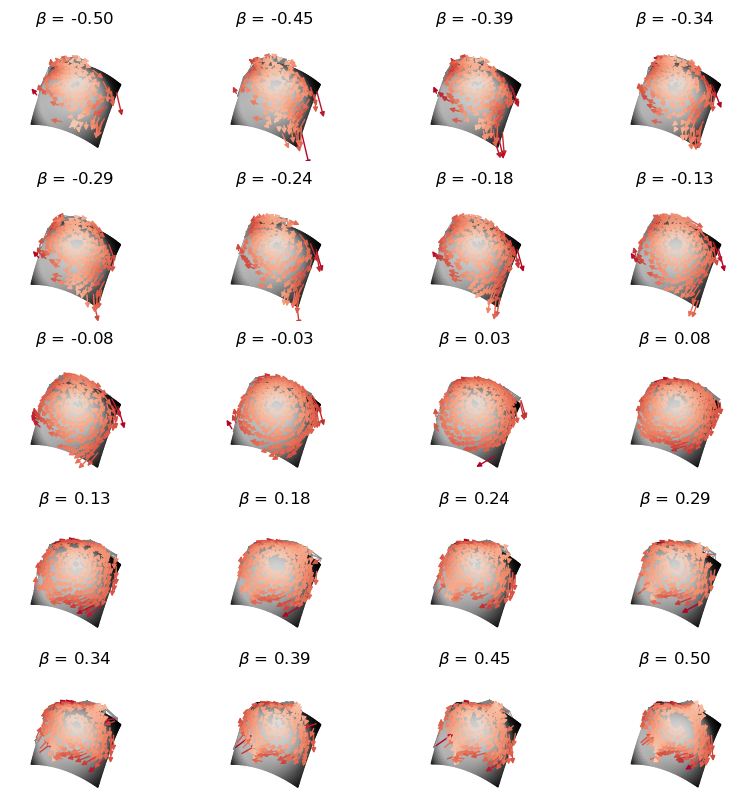

In [9]:
titles = [r'$\beta$ = {:0.2f}'.format(m) for m in mu]

axes = plotting.fields(data, col=4, alpha=1, width=7, scale=2, titles=titles, view=[70,20])
for ax in axes:
    ex_utils.plot_parabola(ax)

#plt.savefig('./outputs/parabolas.svg')

# Train network

In [14]:
par = {'epochs': 50, #optimisation epochs
       'order': 2, #order of derivatives
       'hidden_channels': 32, #number of internal dimensions in MLP
       'out_channels': 5,
       'inner_product_features': True,
      }

model = net(data, **par)
model.run_training(data, outdir='./output/vanderpol_data')
#model.load_model('./output/vanderpol_data/best_model.pth')


---- Settings: 

epochs : 75
order : 2
hidden_channels : 32
out_channels : 5
inner_product_features : True
batch_size : 64
lr : 0.01
momentum : 0.9
diffusion : False
frac_sampled_nb : -1
dropout : 0.0
n_lin_layers : 2
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 3
dim_emb : 3
n_sampled_nb : -1

---- Number of features to pass to the MLP:  13
---- Total number of parameters:  731


# Create embeddings

Performed umap embedding on embedded results.
Performed MDS embedding on embedded results.


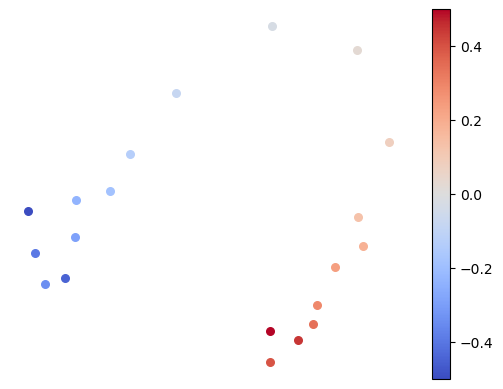

In [15]:
data = model.evaluate(data)
n_clusters=40
data = postprocessing(data, n_clusters=n_clusters)

emb_MDS, _ = geometry.embed(data.dist, embed_typ = 'MDS')
plotting.embedding(emb_MDS, mu, s=30, alpha=1)
#plt.savefig('../results/van_der_pol_MDS.svg')
plt.show()

# Distance matrix

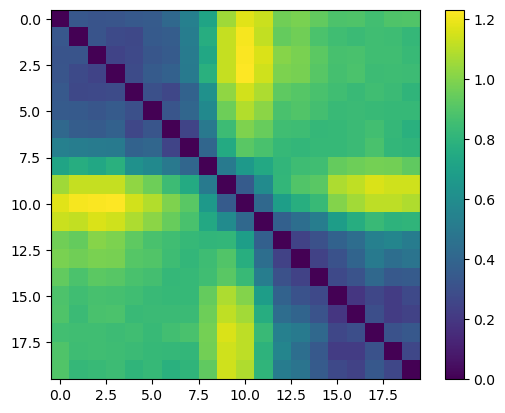

In [16]:
im = plt.imshow(data.dist)
plt.colorbar(im)
#plt.savefig('../results/van_der_pol_D.svg')

# Cluster and visualise embedding

<AxesSubplot:>

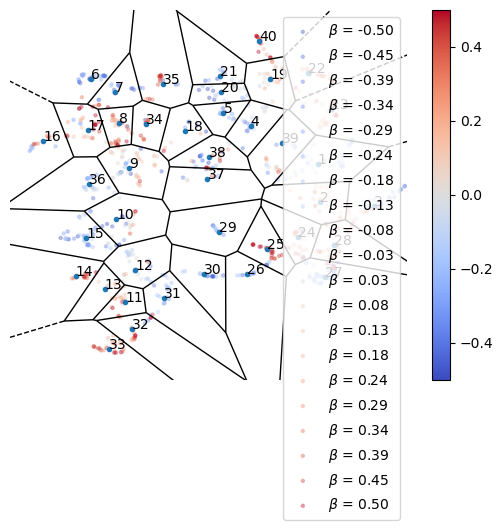

In [17]:
titles = [r'$\beta$ = {:0.2f}'.format(m) for m in mu]
plotting.embedding(data, mu[data.y.numpy().astype(int)], titles=titles)
#plt.savefig('../results/van_der_pol_embedding.svg')